In [ ]:
pip install fastparquet

In [ ]:
pip install -U textblob

In [ ]:
pip install joblib

In [ ]:
pip install wordcloud

In [1]:
#Author_ShyaamPrasadh_Finsurge

%matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [2]:
my_str = "finsurge"
print(Counter(my_str))

Counter({'f': 1, 'i': 1, 'n': 1, 's': 1, 'u': 1, 'r': 1, 'g': 1, 'e': 1})


In [3]:
import collections
my_ord_dict = collections.OrderedDict()
my_ord_dict['f'] = 11
my_ord_dict['i'] = 22
my_ord_dict['n'] = 33
my_ord_dict['s'] = 44
for item in my_ord_dict.items():
   print(item)

('f', 11)
('i', 22)
('n', 33)
('s', 44)


In [4]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
from fastparquet import ParquetFile 
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

In [6]:
from textblob import TextBlob, Word

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
 

In [8]:
import lightgbm as lgb
import json
from time import clock, time

In [9]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Sample_Dataset 


http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

1.6 million training and 350 test tweets starting from thet year 2009 with algorithmically assigned binary positive and negative sentiment scores 

In [11]:
header_list = ["Polarity", "ID", "Date","Query","User","Tweet_Text"]

data= pd.read_csv('/Users/r.shyaamprasadh/Downloads/data/train.csv', encoding='latin-1',names=header_list)

In [12]:
data.head(5)

,Polarity,ID,Date,Query,User,Tweet_Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
data.Polarity.value_counts() 

4    800000
0    800000
Name: Polarity, dtype: int64

Moving the data to faster parqu3et
https://stackoverflow.com/questions/36822224/what-are-the-pros-and-cons-of-parquet-format-compared-to-other-formats

### Data_Preprocessing

In [14]:
import time
start = time.time()
train = (pd.read_csv('/Users/r.shyaamprasadh/Downloads/data/train.csv',
                     low_memory=False,
                     encoding='latin1',
                     header=None,
                     names=header_list,
                     parse_dates=['Date'])
         .drop(['ID', 'Query'], axis=1)
         .drop_duplicates(subset=['Polarity', 'Tweet_Text']))

train = train[train.Tweet_Text.str.len()<=140]
train.Polarity= (train.Polarity>0).astype(int)
print(time.time()-start)

198.75640392303467


In [15]:
train.Polarity.value_counts()

1    784335
0    782333
Name: Polarity, dtype: int64

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566668 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Polarity    1566668 non-null  int64         
 1   Date        1566668 non-null  datetime64[ns]
 2   User        1566668 non-null  object        
 3   Tweet_Text  1566668 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 59.8+ MB


In [17]:
train.to_parquet('/Users/r.shyaamprasadh/Downloads/data/train.parquet')

In [18]:
start = time.time()
test = (pd.read_csv('/Users/r.shyaamprasadh/Downloads/data/test.csv',
                    low_memory=False,
                    encoding='latin1',
                    header=None,
                    names=header_list,
                    parse_dates=['Date'])
        .drop(['ID', 'Query'], axis=1)
        .drop_duplicates(subset=['Polarity', 'Tweet_Text']))

test = test[test.Tweet_Text.str.len()<=140]
test.Polarity= (test.Polarity>0).astype(int)

print(time.time()-start)

0.14211320877075195


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 0 to 497
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Polarity    492 non-null    int64              
 1   Date        492 non-null    datetime64[ns, UTC]
 2   User        492 non-null    object             
 3   Tweet_Text  492 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 19.2+ KB


In [20]:
test.Polarity.value_counts()

1    318
0    174
Name: Polarity, dtype: int64

In [21]:
test.to_parquet('/Users/r.shyaamprasadh/Downloads/data/test.parquet')

In [22]:
train = pd.read_parquet('/Users/r.shyaamprasadh/Downloads/data/train.parquet')
test = pd.read_parquet('/Users/r.shyaamprasadh/Downloads/data/test.parquet')

In [23]:
train.shape

(1566668, 4)

In [24]:
test.shape

(492, 4)

In [25]:
train.head(5)

,Polarity,Date,User,Tweet_Text
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [26]:
test.head(5)

,Polarity,Date,User,Tweet_Text
0,1,2009-05-11 03:17:40+00:00,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,1,2009-05-11 03:18:03+00:00,vcu451,Reading my kindle2... Love it... Lee childs i...
2,1,2009-05-11 03:18:54+00:00,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,1,2009-05-11 03:19:04+00:00,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,1,2009-05-11 03:21:41+00:00,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [27]:
train.Polarity.value_counts()

1    784335
0    782333
Name: Polarity, dtype: int64

In [28]:
test.polarity = (test.Polarity>0).astype(int)
test.Polarity.value_counts()

1    318
0    174
Name: Polarity, dtype: int64

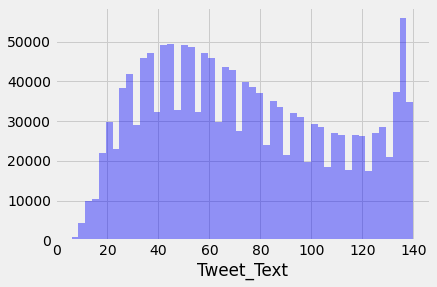

In [29]:
sns.distplot(train.Tweet_Text.str.len(),color='blue',kde=False);

In [30]:
train.Date.describe()

count                 1566668
unique                 765666
top       2009-06-15 12:53:14
freq                       20
first     2009-04-06 22:19:45
last      2009-06-25 10:28:31
Name: Date, dtype: object

In [31]:
train.User.nunique()

650606

In [32]:
test.Date.describe()

count                           492
unique                          492
top       2009-06-02 03:17:55+00:00
freq                              1
first     2009-05-11 03:17:40+00:00
last      2009-06-14 21:36:17+00:00
Name: Date, dtype: object

In [33]:
test.User.nunique()

484

In [34]:
train.User.value_counts()

lost_dog           549
webwoke            341
SallytheShizzle    276
VioletsCRUK        275
mcraddictal        274
                  ... 
HannahBlack          1
muzungukazi          1
broadwaydiva06       1
Fgeelen              1
hhavaic              1
Name: User, Length: 650606, dtype: int64

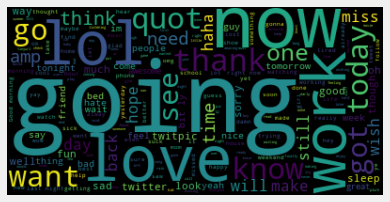

In [35]:
combined_text = " ".join([review for review in train['Tweet_Text']])
wordcloud = WordCloud().generate(combined_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Creating token vectorizer 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [36]:
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')

min_df    

building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 

max_df


building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold


In [37]:
start = time.time()
train_dtm=vectorizer.fit_transform(train.Tweet_Text)#learns the vocabulary of the training data
print(time.time()-start)

18.766005039215088


In [38]:
train_dtm 

<1566668x934 sparse matrix of type '<class 'numpy.int64'>'
	with 6332930 stored elements in Compressed Sparse Row format>

In [39]:
test_dtm = vectorizer.transform(test.Tweet_Text)

### Train Using Naive_Base Classifier 

In [40]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [41]:
%time nb.fit(train_dtm,train.Polarity)

CPU times: user 224 ms, sys: 27.8 ms, total: 252 ms
Wall time: 251 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
predicted_polarity = nb.predict(test_dtm)

In [43]:
error= pd.DataFrame([predicted_polarity,test.Polarity,predicted_polarity-test.Polarity])

In [44]:
error

,0,1,2,3,4,5,6,7,8,9,...,482,483,484,485,486,487,488,489,490,491
0,1,1,0,1,1,1,0,1,1,1,...,1,1,0,1,1,1,0,1,0,0
1,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,0,1,0,0
2,0,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
np.count_nonzero(error, axis=1)

array([318, 318, 102])

In [46]:
accuracy_score(test.Polarity, predicted_polarity)

0.7926829268292683

### Sentiment Analysis using TextBlob

In [47]:
#for index, row in train.iterrows():
    #parsed_positive =TextBlob(row['Tweet_Text'])

In [48]:
h=pd.DataFrame(train.Polarity)
h.to_csv('/Users/r.shyaamprasadh/Downloads/data/polarity.csv')

In [ ]:
sample_positive_sentence= train.Tweet_Text.iloc[993252]
print(sample_positive_sentence)
parsed_positive = TextBlob(sample_positive_sentence)
parsed_positive.polarity

In [ ]:
sample_negative = train.Tweet_Text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

In [ ]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
train[['Tweet_Text']].sample(10).assign(sentiment_textblb =lambda x: x.Tweet_Text.apply(estimate_polarity)).sort_values('sentiment_textblb')

In [ ]:
test['Sentiment_using_textblob'] =test.Tweet_Text.apply(estimate_polarity)

In [ ]:
test

In [ ]:
accuracy_score(test.Polarity, (test.Sentiment_using_textblob>0).astype(int))

In [ ]:
roc_auc_score(y_true=test.Polarity, y_score=test.Sentiment_using_textblob)

In [ ]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.Polarity, y_score=test.Sentiment_using_textblob)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.Polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='Polarity', y='Sentiment_using_textblob', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
fig.tight_layout();